## Background

Power generation is a complex process, and understanding and predicting power output is an important element in managing a plant and its connection to the power grid. The operators of a regional power grid create predictions of power demand based on historical information and environmental factors (e.g., temperature). They then compare the predictions against available resources (e.g., coal, natural gas, nuclear, solar, wind, hydro power plants). Power generation technologies such as solar and wind are highly dependent on environmental conditions, and all generation technologies are subject to planned and unplanned maintenance.

Here is an real-world example of predicted demand (on two time scales), actual demand, and available resources from the California power grid: http://www.caiso.com/Pages/TodaysOutlook.aspx

![](http://content.caiso.com/outlook/SP/ems_small.gif)

The challenge for a power grid operator is how to handle a shortfall in available resources versus actual demand. There are three solutions to  a power shortfall: build more base load power plants (this process can take many years to decades of planning and construction), buy and import power from other regional power grids (this choice can be very expensive and is limited by the power transmission interconnects between grids and the excess power available from other grids), or turn on small [Peaker or Peaking Power Plants](https://en.wikipedia.org/wiki/Peaking_power_plant). Because grid operators need to respond quickly to a power shortfall to avoid a power outage, grid operators rely on a combination of the last two choices. In this exercise, we'll focus on the last choice.

Because they supply power only occasionally, the power supplied by a peaker power plant commands a much higher price per kilowatt hour than power from a power grid's base power plants. A peaker plant may operate many hours a day, or it may operate only a few hours per year, depending on the condition of the region's electrical grid. Because of the cost of building an efficient power plant, if a peaker plant is only going to be run for a short or highly variable time it does not make economic sense to make it as efficient as a base load power plant. In addition, the equipment and fuels used in base load plants are often unsuitable for use in peaker plants because the fluctuating conditions would severely strain the equipment.

The power output of a peaker power plant varies depending on environmental conditions, so the business problem is _predicting the power output of a peaker power plant as a function of the environmental conditions_ -- since this would enable the grid operator to make economic tradeoffs about the number of peaker plants to turn on (or whether to buy expensive power from another grid).

## Problem Definition

Given the background information, we need to first perform Exploratory Data Analysis to understand the data and then translate the business problem (predicting power output as a function of envionmental conditions) into a Machine Learning task.  In this instance, the ML task is regression since the label (or target) we are trying to predict is numeric. We will use an [Apache Spark ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark-ml-package) to perform the regression.

## Create a DataFrame from the data

The schema definition from UCI appears below:
* AT = Atmospheric Temperature in C
* V = Exhaust Vacuum Speed
* AP = Atmospheric Pressure
* RH = Relative Humidity
* PE = Power Output. This is the value we are trying to predict given the measurements above.

In [2]:
powerPlantDF = sqlContext.read.format("com.databricks.spark.csv")\
                              .options(delimiter=',', header='true', inferschema='true')\
                              .load("data.csv")

In [3]:
# Check the names and types of the columns
print powerPlantDF.dtypes

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]


## Explore Data

In [4]:
# Register powerPlantDF as an SQL table
sqlContext.sql("DROP TABLE IF EXISTS power_plant")
sqlContext.registerDataFrameAsTable(powerPlantDF, "power_plant")

In [5]:
sqlContext.sql("SELECT * FROM power_plant").show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
| 8.34|40.77|1010.84|90.01|480.48|
|23.64|58.49| 1011.4| 74.2|445.75|
|29.74| 56.9|1007.15|41.91|438.76|
|19.07|49.69|1007.22|76.79|453.09|
| 11.8|40.66|1017.13| 97.2|464.43|
+-----+-----+-------+-----+------+
only showing top 5 rows



In [6]:
sqlContext.sql("desc power_plant").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|      AT|   double|   null|
|       V|   double|   null|
|      AP|   double|   null|
|      RH|   double|   null|
|      PE|   double|   null|
+--------+---------+-------+



In [7]:
powerPlantDF.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|                AT|                 V|                AP|                RH|               PE|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|              9568|              9568|              9568|              9568|             9568|
|   mean|19.651231187291014|54.305803720735966|1013.2590781772483| 73.30897784280928|454.3650094063547|
| stddev| 7.452473229611075|12.707892998326807| 5.938783705811638|14.600268756728957|17.06699499980342|
|    min|              1.81|             25.36|            992.89|             25.56|           420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|           495.76|
+-------+------------------+------------------+------------------+------------------+-----------------+



In [8]:
powerPlantDF.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
| 8.34|40.77|1010.84|90.01|480.48|
|23.64|58.49| 1011.4| 74.2|445.75|
|29.74| 56.9|1007.15|41.91|438.76|
|19.07|49.69|1007.22|76.79|453.09|
| 11.8|40.66|1017.13| 97.2|464.43|
+-----+-----+-------+-----+------+
only showing top 5 rows



In [9]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [10]:
pd_powerPlant = powerPlantDF.toPandas()

It looks like there is strong linear correlation between Temperature and Power Output.

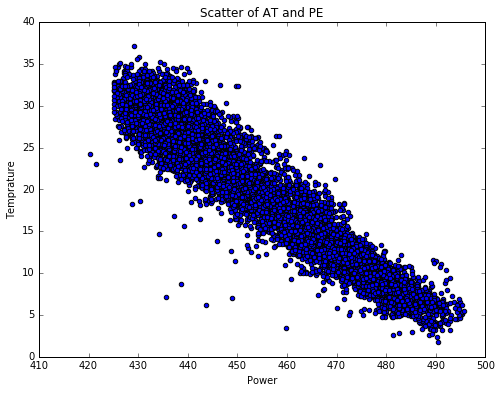

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(pd_powerPlant.PE, pd_powerPlant.AT)
plt.xlabel('Power')
plt.ylabel('Temprature')
plt.title('Scatter of AT and PE');

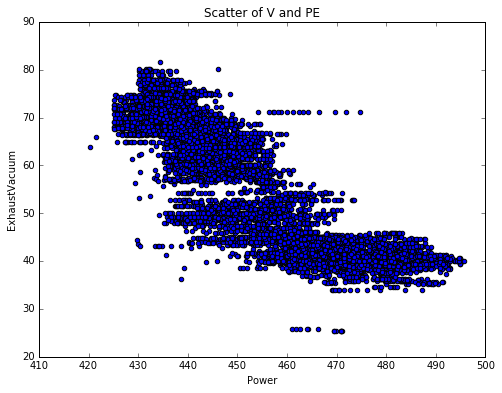

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(pd_powerPlant.PE, pd_powerPlant.V)
plt.xlabel('Power')
plt.ylabel('ExhaustVacuum')
plt.title('Scatter of V and PE');

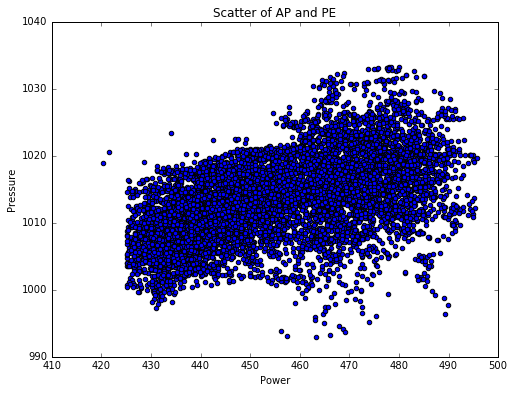

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(pd_powerPlant.PE, pd_powerPlant.AP)
plt.xlabel('Power')
plt.ylabel('Pressure')
plt.title('Scatter of AP and PE');

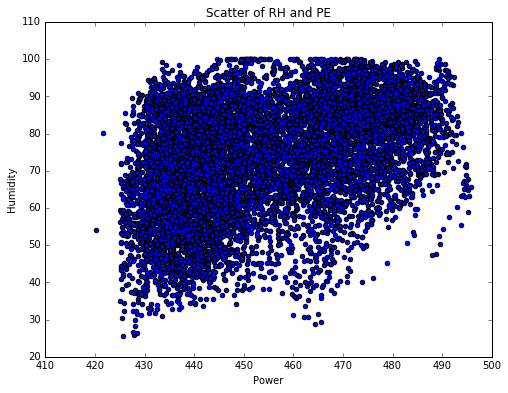

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(pd_powerPlant.PE, pd_powerPlant.RH)
plt.xlabel('Power')
plt.ylabel('Humidity')
plt.title('Scatter of RH and PE');

## Data Preparation

The goal is to use machine learning to determine a function that yields the output power as a function of a set of predictor features. The first step in building our ML pipeline is to convert the predictor features from DataFrame columns to Feature Vectors using the ** pyspark.ml.feature.VectorAssembler() ** method.

The VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. VectorAssembler takes a list of input column names (each is a string) and the name of the output column (as a string).

In [15]:
from pyspark.ml.feature import VectorAssembler

vectorizer = VectorAssembler()
vectorizer.setInputCols(["AT", "V", "AP", "RH"])
vectorizer.setOutputCol("features")

VectorAssembler_4ceb80e267db095c6d46

## Data Modeling

Now let's model our data to predict what the power output will be given a set of sensor readings. Our first model will be based on simple linear regression since we saw some linear patterns in our data based on the scatter plots during the exploration stage.

We need a way of evaluating how well our linear regression model predicts power output as a function of input parameters. We can do this by splitting up our initial data set into a Training Set used to train our model and a Test Set used to evaluate the model's performance in giving predictions. We can use a DataFrame's ** randomSplit() ** method to split our dataset. The method takes a list of weights and an optional random seed. The seed is used to initialize the random number generator used by the splitting function.

In [16]:
# We'll hold out 20% of our data for testing and leave 80% for training
seed = 1800009193L
(split20DF, split80DF) = powerPlantDF.randomSplit([0.2, 0.8], seed)

testSetDF = split20DF
trainingSetDF = split80DF

### Linear Regression Model

In [17]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Let's initialize our linear regression learner
lr = LinearRegression()

# Now we set the parameters for the method
lr.setPredictionCol("Predicted_PE")\
  .setLabelCol("PE")\
  .setFeaturesCol("features")\
  .setMaxIter(100)\
  .setRegParam(0.1)
    
lrPipeline = Pipeline()
lrPipeline.setStages([vectorizer, lr])

# Let's train begins
lrModel = lrPipeline.fit(trainingSetDF)

Let's see what's this model telling us

In [18]:
# The intercept is as follows:
intercept = lrModel.stages[1].intercept

# The coefficents (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# Create a list of the column names (without PE)
featuresNoLabel = [col for col in powerPlantDF.columns if col != "PE"]

# Merge the weights and labels
coefficents = zip(weights, featuresNoLabel)

# Now let's sort the coefficients from greatest absolute weight most to the least absolute weight
coefficents.sort(key=lambda tup: abs(tup[0]), reverse=True)

equation = "y = {intercept}".format(intercept=intercept)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation: " + equation)

Linear Regression Equation: y = 427.913982218 - (1.90830649191 * AT) - (0.253812930071 * V) - (0.147465130103 * RH) + (0.0873935030455 * AP)


In [19]:
# Apply our LR model to the test data and predict power output
predictionsAndLabelsDF = lrModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")
predictionsAndLabelsDF.show(5)

+----+-----+-------+-----+------+------------------+
|  AT|    V|     AP|   RH|    PE|      Predicted_PE|
+----+-----+-------+-----+------+------------------+
|1.81|39.42|1026.92|76.97|490.55| 492.8503868480957|
| 3.2|41.31| 997.67|98.84|489.86|483.93681202706864|
|3.38|41.31| 998.79|97.76|489.11| 483.8504599224484|
| 3.4|39.64| 1011.1|83.43|459.86| 487.4251507227025|
|3.51|35.47|1017.53|86.56|489.07|488.37401129434926|
+----+-----+-------+-----+------+------------------+
only showing top 5 rows



RSME is defined as follows: \\( RMSE = \sqrt{\frac{\sum_{i = 1}^{n} (x_i - y_i)^2}{n}}\\) where \\(y_i\\) is the observed value and \\(x_i\\) is the predicted value

RMSE is a frequently used measure of the differences between values predicted by a model or an estimator and the values actually observed. The lower the RMSE, the better our model.

In [20]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol="Predicted_PE", labelCol="PE", metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsAndLabelsDF)

print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 4.61


Another useful statistical evaluation metric is the ** coefficient of determination **, denoted \\(R^2\\) or \\(r^2\\) and pronounced ** "R squared" **. It is a number that indicates the proportion of the variance in the dependent variable that is predictable from the independent variable and it provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. The coefficient of determination ranges from 0 to 1 (closer to 1), and the higher the value, the better our model.

In [21]:
# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("r2: {:.2f}".format(r2))

r2: 0.93


Generally, assuming a Gaussian distribution of errors, a good model will have 68% of predictions within 1 RMSE and 95% within 2 RMSE of the actual value.

Let's examine the predictions and see if a RMSE of 4.61 meets this criteria.

In [22]:
sqlContext.sql("DROP TABLE IF EXISTS Power_Plant_RMSE_Evaluation")
predictionsAndLabelsDF.selectExpr("PE", "Predicted_PE", "PE - Predicted_PE Residual_Error", \
                                  "(PE - Predicted_PE) / {} Within_RSME".format(rmse))\
                      .registerTempTable("Power_Plant_RMSE_Evaluation")

In [23]:
sqlContext.sql("SELECT * from Power_Plant_RMSE_Evaluation").show(5)

+------+------------------+------------------+--------------------+
|    PE|      Predicted_PE|    Residual_Error|         Within_RSME|
+------+------------------+------------------+--------------------+
|490.55| 492.8503868480957|-2.300386848095684|-0.49906688418980644|
|489.86|483.93681202706864| 5.923187972931373|  1.2850303715518543|
|489.11| 483.8504599224484|5.2595400775516055|  1.1410525498996038|
|459.86| 487.4251507227025|-27.56515072270247|  -5.980234974299983|
|489.07|488.37401129434926|0.6959887056507341| 0.15099413172525689|
+------+------------------+------------------+--------------------+
only showing top 5 rows



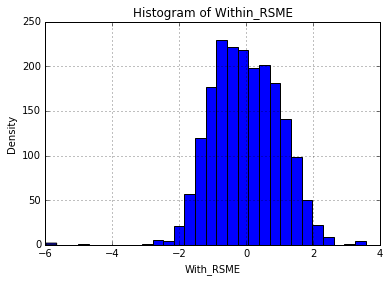

In [24]:
sqlContext.sql("SELECT Within_RSME from Power_Plant_RMSE_Evaluation").toPandas().hist(bins=30)
plt.ylabel('Density')
plt.xlabel('With_RSME')
plt.title('Histogram of Within_RSME');

In [25]:
sql = "SELECT case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1 \
                   when  Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3 \
              end RSME_Multiple, COUNT(*) AS Count \
       FROM Power_Plant_RMSE_Evaluation \
       GROUP BY case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1  \
                     when  Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3 end"
RSME = sqlContext.sql(sql).toPandas()

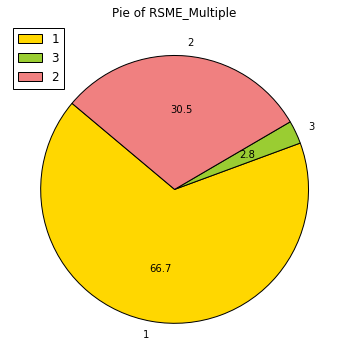

In [26]:
plt.figure(figsize=(6,6))
plt.pie(RSME.Count, labels=RSME.RSME_Multiple, autopct="%1.1f", colors=['gold', 'yellowgreen', 'lightcoral']
        , startangle=140)
plt.title("Pie of RSME_Multiple")
plt.legend(loc="best");

Right now, Linear model seems working pretty well. But we still need to go through Hyperparameter Turing to make sure we have the best model.

In [27]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np

# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# We'll create a paramter grid using the ParamGridBuilder, and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, np.linspace(0.01, 0.1, 10))
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

In [28]:
# Now let's use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = cvModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Compute the RMSE evaluation metric for our test dataset
rmseLR = regEval.evaluate(predictionsAndLabelsDF)

# Compute the r2 evaluation metric for our test dataset
r2LR = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2LR))

Original Root Mean Squared Error: 4.61
New Root Mean Squared Error: 4.60
Old r2: 0.93
New r2: 0.93


Let's look at which regularization parameter is the best.

In [55]:
print("Regularization parameter of the best model: {0:.2f}".format(cvModel.stages[1]._java_obj.parent().getRegParam()))

Regularization parameter of the best model: 0.01


## Decision Tree Regressor

In [56]:
from pyspark.ml.regression import DecisionTreeRegressor

# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
  .setSeed(100088121L)\
  .setMaxBins(100)

# Create a Pipeline
dtPipeline = Pipeline()

# Set the stages of the Pipeline
dtPipeline.setStages([vectorizer, dt])

Pipeline_43bb959a3a38628f3915

In [57]:
crossval.setEstimator(dtPipeline)

# Let's tune over our dt.maxDepth parameter on the values 1 to 5
paramGrid = (ParamGridBuilder().addGrid(dt.maxDepth, range(1, 6)).build())

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
dtModel = crossval.fit(trainingSetDF).bestModel

In [69]:
predictionsAndLabelsDF = dtModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Compute the RMSE evaluation metric for our test dataset
rmseDT = regEval.evaluate(predictionsAndLabelsDF)

# Compute the r2 evaluation metric for our test dataset
r2DT = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("LR Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("DT Root Mean Squared Error: {0:2.2f}".format(rmseDT))
print("LR r2: {0:2.2f}".format(r2LR))
print("DT r2: {0:2.2f}".format(r2DT))

LR Root Mean Squared Error: 4.60
DT Root Mean Squared Error: 4.45
LR r2: 0.93
DT r2: 0.94


We could see that Decision Tree Regressor is slightly better than Linear Regression.

In [65]:
print dtModel.stages[-1]._java_obj.toDebugString().split("\n")[0]

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_43e492aeb5bd38e7bc4c) of depth 5 with 63 nodes


## Random Forest 

In [66]:
from pyspark.ml.regression import RandomForestRegressor

# Create a RandomForestRegressor
rf = RandomForestRegressor()

rf.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
  .setSeed(100088121L)\
  .setMaxDepth(8)\
  .setNumTrees(30)

# Create a Pipeline
rfPipeline = Pipeline()

# Set the stages of the Pipeline
rfPipeline.setStages([vectorizer, rf])

Pipeline_4199908612cfa27e68e7

In [67]:
crossval.setEstimator(rfPipeline)

# Let's tune over our rf.maxBins parameter on the values 30 to 100 with step 20
paramGrid = (ParamGridBuilder().addGrid(rf.maxBins, np.arange(30, 100, 20)).build())

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
rfModel = crossval.fit(trainingSetDF).bestModel

In [70]:
predictionsAndLabelsDF = rfModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseRF = regEval.evaluate(predictionsAndLabelsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2RF = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("LR Root Mean Squared Error: {0:.2f}".format(rmseLR))
print("DT Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("RF Root Mean Squared Error: {0:.2f}".format(rmseRF))
print("LR r2: {0:.2f}".format(r2LR))
print("DT r2: {0:.2f}".format(r2DT))
print("RF r2: {0:.2f}".format(r2RF))

LR Root Mean Squared Error: 4.60
DT Root Mean Squared Error: 4.45
RF Root Mean Squared Error: 3.91
LR r2: 0.93
DT r2: 0.94
RF r2: 0.95


In [71]:
print rfModel.stages[-1]._java_obj.toDebugString().split("\n")[0]

RandomForestRegressionModel (uid=rfr_f8074c3d43f1) with 30 trees


## Conclusion

In the end, we could see that Random Forest is the best model of the three. 

This notebook is an end-to-end tutorial of performing Extract-Transform-Load and Exploratory Data Analysis on a real-world dataset, and then applying several different machine learning algorithms to solve a supervised regression problem on the dataset.